# NLP: Salary predictions based on the job description

### Project Goal
To predict the salary level based on the vacancy description.

### Variables Description
* ```name``` - название вакансии
* ```experience``` - опыт работы, требуемый от соискателя [категориальный]
* ```schedule``` - расписание [категориальный]
* ```employment``` - вид занятости [категориальный]
* ```description``` - непосредственно описание вакансии
* ```key_skills``` - ключевые навыки в формате python-списка (много пропусков)
* ```salary``` - целевая переменная (зарплата)

### Data
Link to the dataset is [here](https://drive.google.com/drive/folders/1u-9QPp7107NYN729nisHSnQ9guT8-5kT?usp=sharing).
- vacancies_train.csv - the training set
- vacancies_test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format

In [178]:
import re

import matplotlib.pyplot as plt
import nltk
import pandas as pd

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dropout
import numpy as np
from keras.layers import Dense
from sklearn.metrics import r2_score

tqdm.pandas()
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import word2vec

plt.rcParams["figure.figsize"] = [12, 8]

import warnings

import seaborn as sns
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Data Load


In [158]:
df_train = pd.read_csv("C:\\Users\\HOME\\PycharmProjects\\NLP_SalaryPrediction\\vacancies_train.csv")
df_train.head(8)

,name,experience,schedule,employment,description,key_skills,salary
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0
5,Менеджер-администратор,От 1 года до 3 лет,Полный день,Полная занятость,Международная сеть Школ скорочтения и развития...,"['Навыки межличностного общения', 'Грамотная р...",50000.0
6,Комплектовщик,Нет опыта,Полный день,Полная занятость,Мы прямой работодатель - компания «Форум-Авто»...,"['1С: Склад', 'Работа с оргтехникой', 'Приемка...",53500.0
7,Медицинская сестра,Нет опыта,Гибкий график,Частичная занятость,Работа на территории работодателя: р-н Кущевск...,"['Медицинская документация', 'Лечебная деятель...",12130.0


In [159]:
df_test = pd.read_csv("C:\\Users\\HOME\\PycharmProjects\\NLP_SalaryPrediction\\vacancies_test.csv", index_col=0)
df_test.head(10)

,name,experience,schedule,employment,description,key_skills
id,,,,,,
0,Главный бухгалтер,Более 6 лет,Полный день,Полная занятость,Обязанности:Осуществление организации бухгалте...,"['1С: Предприятие 8', '1C: Предприятие', 'Рабо..."
1,Ассистент врача-стоматолога,От 1 года до 3 лет,Сменный график,Полная занятость,"Обязанности: Ассистировать врачу стоматологу,...","['Пользователь ПК', 'Работа в команде', 'Умени..."
2,Менеджер по продажам,От 1 года до 3 лет,Полный день,Полная занятость,Если ты: хочешь построить карьеру в банковс...,[]
3,Менеджер,От 1 года до 3 лет,Полный день,Полная занятость,Динамично развивающаяся на протяжении 17 лет...,"['Оценка потребностей клиентов', 'оформление д..."
4,Администратор хостела,Нет опыта,Сменный график,Полная занятость,ВОЗМОЖНА РАБОТА С ПРОЖИВАНИЕМ Обязанности: Пр...,[]
5,Полицейский (г. Москва),Нет опыта,Полный день,Полная занятость,Обязанности:- обеспечение правопорядка при мас...,[]
6,Менеджер по работе с клиентами,От 1 года до 3 лет,Гибкий график,Полная занятость,Обязанности: Консультирование клиентов в студ...,"['Заключение договоров', 'Навыки продаж', 'Кон..."
7,Администратор,Нет опыта,Полный день,Полная занятость,Приглашаем администратора в стоматологическую ...,"['Пользователь ПК', 'Работа с кассой', 'Грамот..."
8,Кредитный специалист,Нет опыта,Полный день,Полная занятость,Обязанности: - консультирование клиентов по фи...,"['Грамотная речь', '1С: Предприятие 8', 'Консу..."


## Preprocessing

In [160]:
# option 1 to clean the text
stop_words = set(stopwords.words('russian'))
m = MorphAnalyzer()

def words_only(text, regex=re.compile("[а-яa-zёЁ]+")):
    try:
        return regex.findall(text.lower())
    except:
        return []

# @lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

def remove_stopwords(lemmas, stopwords = stop_words):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def to_tokens_lemmas(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    return ' '.join(remove_stopwords(lemmas))

In [161]:
# option 2 to clean the text
stop_words = set(stopwords.words('russian'))
m = MorphAnalyzer()

# функция для очистки описаний
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # избавляемся от ссылок
    text = re.sub('[^а-яёА-ЯЁ]', ' ', text)  # оставляем только кириллицу
    text = word_tokenize(text.lower())  # приводим к нижнему регистру и токенизируем по словам
    # приводим токены к нормальной форме, удаляем стоп-слова и короткие токены
    text = [m.normal_forms(token)[0] for token in text
            if token not in stop_words and len(token) > 2]
    text = " ".join(text)  # возвращаем строку
    return text

In [162]:
df_train.columns

Index(['name', 'experience', 'schedule', 'employment', 'description',
       'key_skills', 'salary'],
      dtype='object')

In [163]:
df_train_new = pd.DataFrame()
df_train_new['text'] = df_train.name \
                       + ' ' + df_train.description.apply(str) \
                       + ' ' + df_train.schedule.apply(str) \
                       + ' ' + df_train.employment.apply(str) \
                       + ' ' + df_train.experience.apply(str) \
                       + ' ' + df_train.key_skills.apply(str)

df_test_new = pd.DataFrame()
df_test_new['text'] = df_test.name.apply(str) \
                       + ' ' + df_test.description.apply(str) \
                       + ' ' + df_test.schedule.apply(str) \
                       + ' ' + df_test.employment.apply(str) \
                       + ' ' + df_test.experience.apply(str) \
                       + ' ' + df_test.key_skills.apply(str)

In [164]:
%%time
df_train_new['clean'] = df_train_new['text'].apply(clean_text)
df_train_new.head(5)

CPU times: total: 3min 10s
Wall time: 3min 49s


,text,clean
0,Водитель-экспедитор Водитель-экспедитор катего...,водитель экспедитор водитель экспедитор катего...
1,Кладовщик-комплектовщик/оператор 1С Обязанност...,кладовщик комплектовщик оператор обязанность с...
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",продавец магазин магнит кировский уса крупный ...
3,Администратор магазина (ТЦ Spar) Крупная федер...,администратор магазин крупный федеральный сеть...
4,Мойщик посуды (кулинария) Обязанности: Уборка...,мойщик посуда кулинария обязанность уборка про...


In [165]:
%%time
df_test_new['clean'] = df_test_new['text'].apply(clean_text)
df_test_new.head(5)

CPU times: total: 1min 7s
Wall time: 1min 18s


,text,clean
id,,
0,Главный бухгалтер Обязанности:Осуществление ор...,главный бухгалтер обязанность осуществление ор...
1,Ассистент врача-стоматолога Обязанности: Асси...,ассистент врач стоматолог обязанность ассистир...
2,Менеджер по продажам Если ты: хочешь постро...,менеджер продажа хотеть построить карьера банк...
3,Менеджер Динамично развивающаяся на протяжен...,менеджер динамично развивающийся протяжение го...
4,Администратор хостела ВОЗМОЖНА РАБОТА С ПРОЖИВ...,администратор хостел возможный работа проживан...


In [166]:
train_clean = df_train_new[['clean']]
test_clean = df_test_new[['clean']]

In [169]:
train_final = pd.concat([train_clean.clean, df_train.salary], axis=1)
train_final.head(5)

test_final = test_clean.copy()
test_final.to_csv('actual_test_data.csv')

In [170]:
train_final['clean'] = train_final['clean'].values.astype('U')
test_final['clean'] = test_final['clean'].values.astype('U')

train_final['clean'] = train_final['clean'].values.astype('U')

## EDA

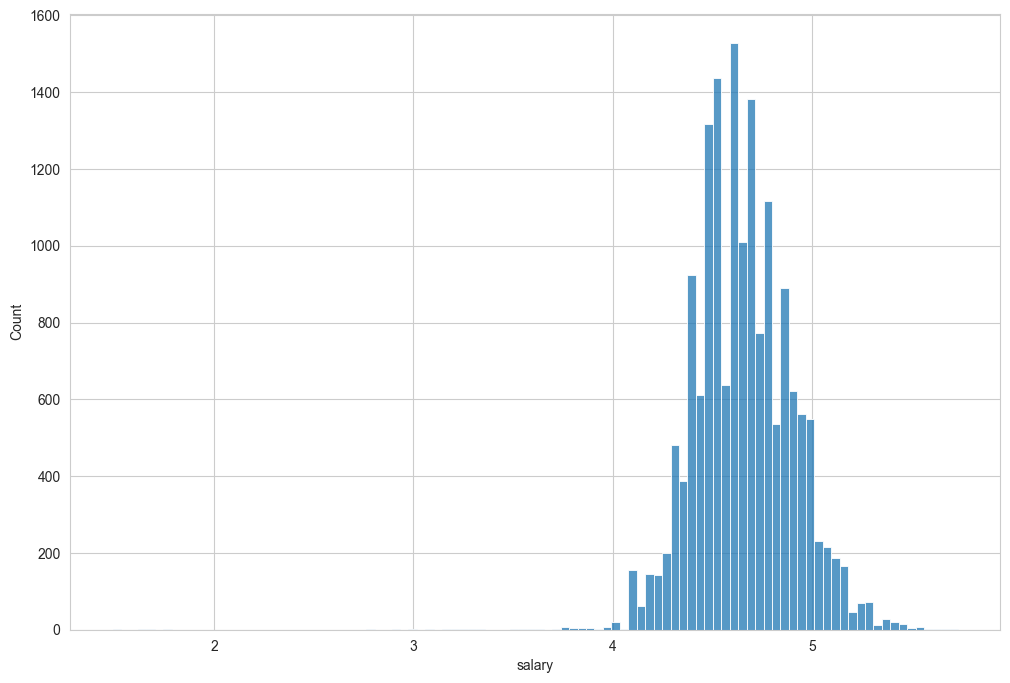

In [171]:
sns.histplot(np.log10(df_train.salary + 1), bins=100);

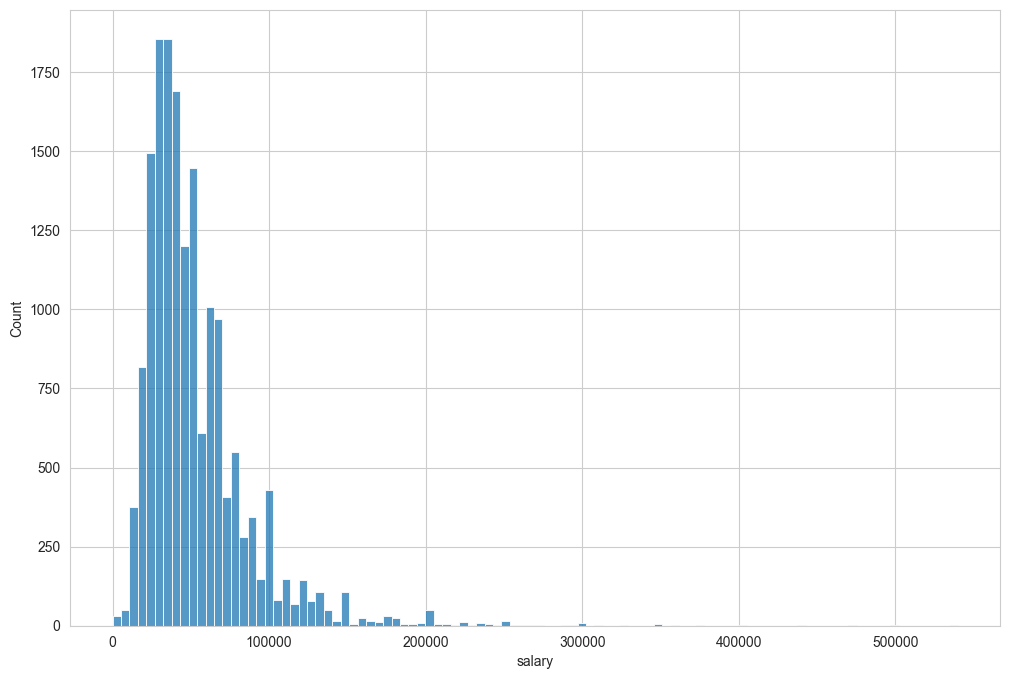

In [14]:
sns.histplot(df_train.salary, bins=100);

In [15]:
df_train.name.value_counts()

Менеджер по продажам                                          208
Продавец-консультант                                          180
Менеджер по работе с клиентами                                111
Кладовщик                                                     111
Бухгалтер                                                     108
                                                             ... 
Упаковщица/Упаковщик                                            1
Помощник официанта,ранер                                        1
Менеджер по продаже оборудования для общепита и торговли        1
Электросварщик на полуавтомат (морской регистр, НАКС НГДО)      1
Специалист-эксперт отдела правового обеспечения                 1
Name: name, Length: 9915, dtype: int64

In [16]:
df_test.name.value_counts()

Менеджер по продажам                                                70
Продавец-консультант                                                65
Кладовщик                                                           51
Менеджер по работе с клиентами                                      36
Медицинская сестра                                                  34
                                                                    ..
Disposal (диспозл)-менеджер по привлечению объектов недвижимости     1
Товаровед-Продавец                                                   1
Слесарь-ремонтник (5 разряд)                                         1
Повар (Камчатский край, Артель)                                      1
Торговый представитель (Колпино, Тосно, Кировск)                     1
Name: name, Length: 3716, dtype: int64

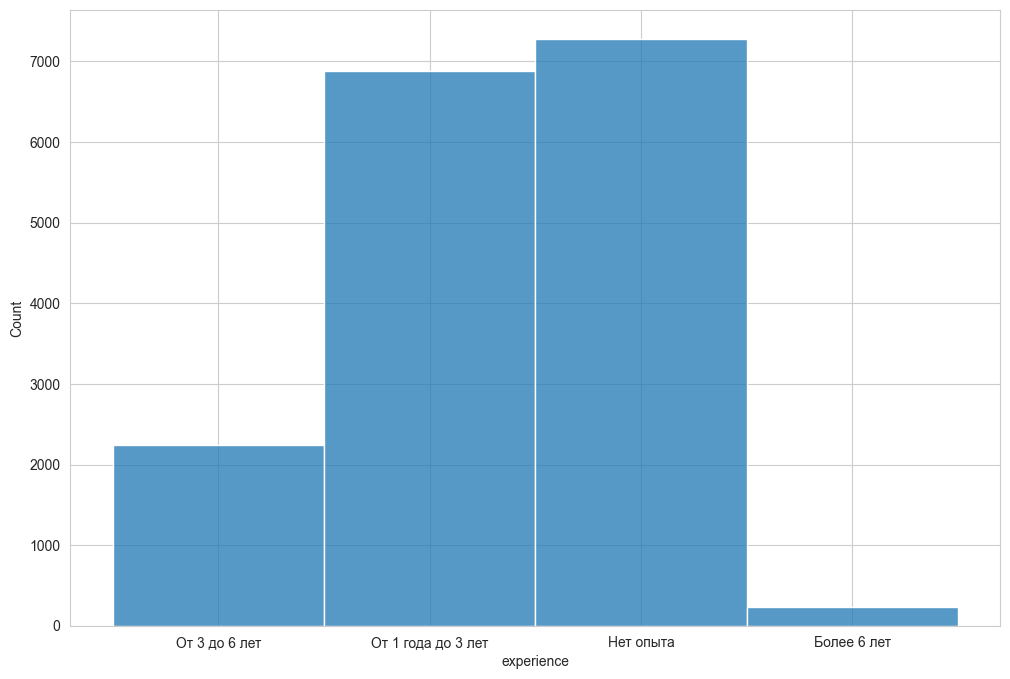

In [17]:
sns.histplot(df_train.experience);

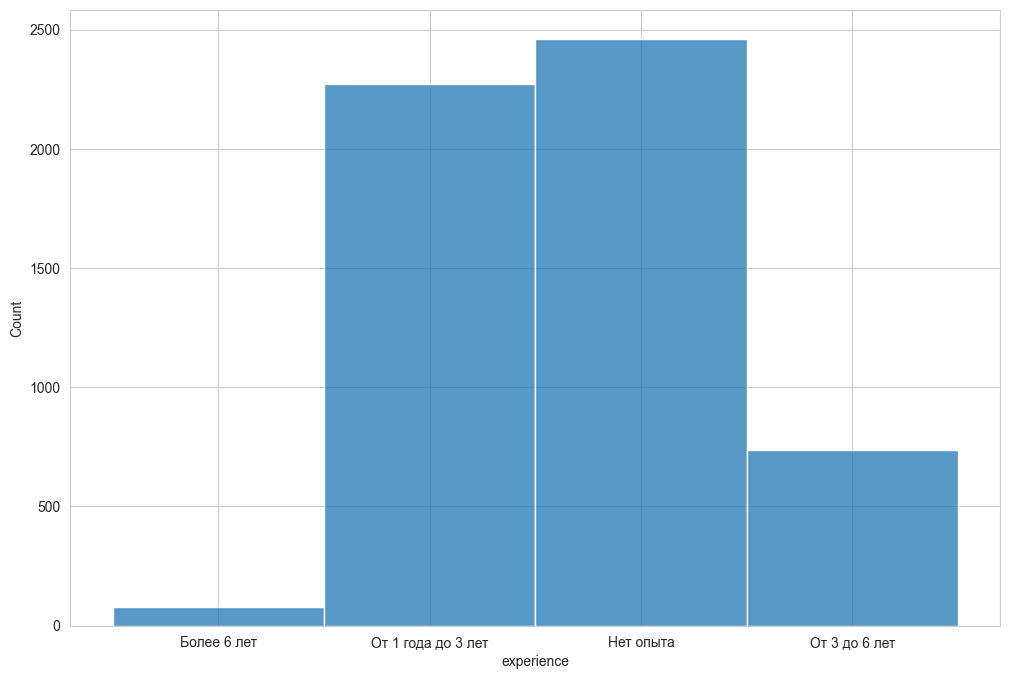

In [18]:
sns.histplot(df_test.experience);

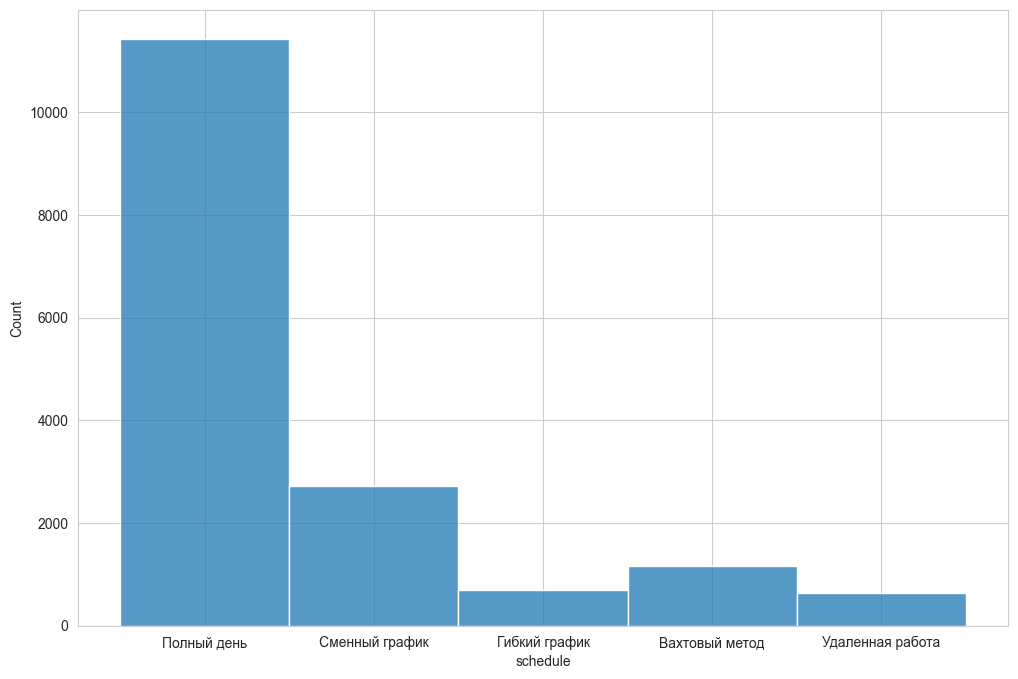

In [19]:
sns.histplot(df_train.schedule);

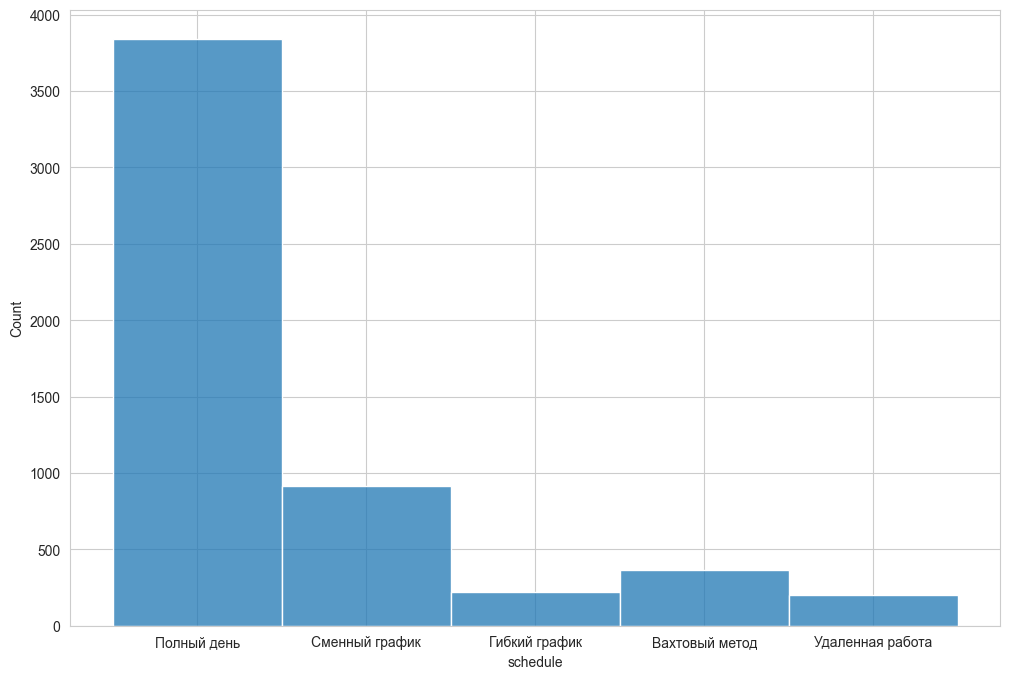

In [20]:
sns.histplot(df_test.schedule);

## Модели

In [110]:
vec = CountVectorizer(ngram_range=(1, 1), token_pattern=r'\b\w+\b')

bow_train = vec.fit_transform(train_final['clean'])
bow_train

bow_test = vec.transform(test_final['clean'])
bow_test

<5543x29597 sparse matrix of type '<class 'numpy.int64'>'
	with 482183 stored elements in Compressed Sparse Row format>

In [111]:
list(vec.vocabulary_.items())[:10]

[('водитель', 3465),
 ('экспедитор', 28895),
 ('категория', 9066),
 ('газель', 4337),
 ('тент', 25110),
 ('цельнометаллический', 27912),
 ('газ', 4332),
 ('фургон', 27510),
 ('обязанность', 15115),
 ('развоз', 20424)]

### 1) CatBoost Regressor with BoW

In [112]:
from sklearn.preprocessing import MaxAbsScaler

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(bow_train, train_final['salary'].values, test_size=0.2, random_state=5)

# Calculate the minimum and maximum values
scaler = MaxAbsScaler().fit(bow_train)

# Scale the training data
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test data and evaluate the performance on the scaled data
X_test_scaled = scaler.transform(X_test)

In [114]:
%%time
# Define the hyperparameter grid to search over
param_grid = {
    'depth': [3, 7],
    'learning_rate': [0.1, 1],
    # 'l2_leaf_reg': [1, 3, 5]
}

# Perform grid search over the hyperparameters
catboost = CatBoostRegressor(loss_function='RMSE', verbose=1000)
grid_search = GridSearchCV(catboost, param_grid=param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

0:	learn: 34212.9574284	total: 45ms	remaining: 45s
999:	learn: 19900.1615929	total: 27s	remaining: 0us
0:	learn: 34214.4458962	total: 35.8ms	remaining: 35.8s
999:	learn: 19802.9237027	total: 29.9s	remaining: 0us
0:	learn: 33548.0136671	total: 46.1ms	remaining: 46.1s
999:	learn: 19400.6583433	total: 27.4s	remaining: 0us
0:	learn: 34909.4529640	total: 29ms	remaining: 29s
999:	learn: 20172.5328214	total: 28.9s	remaining: 0us
0:	learn: 34553.5933550	total: 30.2ms	remaining: 30.2s
999:	learn: 19890.8155856	total: 31.5s	remaining: 0us
0:	learn: 31585.7680574	total: 27.8ms	remaining: 27.8s
999:	learn: 9580.6095189	total: 35.6s	remaining: 0us
0:	learn: 31777.3546395	total: 42ms	remaining: 42s
999:	learn: 9539.3133654	total: 31.3s	remaining: 0us
0:	learn: 31031.7290423	total: 35.1ms	remaining: 35.1s
999:	learn: 9140.1606452	total: 28.2s	remaining: 0us
0:	learn: 32592.4676483	total: 31.1ms	remaining: 31.1s
999:	learn: 9713.7913060	total: 30.9s	remaining: 0us
0:	learn: 31950.5373701	total: 33ms	r

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001FEE9E59670>,
             param_grid={'depth': [3, 7], 'learning_rate': [0.1, 1]})

In [115]:
 # наилучшие гиперпараметры, подобранные поиском по сетке
grid_search.best_params_

{'depth': 7, 'learning_rate': 0.1}

In [116]:
%%time
final_cat = CatBoostRegressor(depth=grid_search.best_params_['depth'],
        # l2_leaf_reg=grid_search.best_params_['l2_leaf_reg'],
        learning_rate=grid_search.best_params_['learning_rate'],
        loss_function='RMSE',
        verbose=500)

final_cat.fit(X_train_scaled, y_train)

0:	learn: 34001.6861940	total: 99.1ms	remaining: 1m 38s
500:	learn: 18381.9048702	total: 57.8s	remaining: 57.6s
999:	learn: 14845.7887002	total: 2m 8s	remaining: 0us
CPU times: total: 3min 11s
Wall time: 2min 9s


In [117]:
best_params = final_cat.get_params()
print("Best Hyperparameters CatBoost Regressor: ", best_params)

y_pred_mse = final_cat.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred_mse)
print("MSE CatBoost Regressor: ", mse)

print()
y_pred_r2 = final_cat.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred_r2)
print("R2 Score: ", r2)

Best Hyperparameters CatBoost Regressor:  {'learning_rate': 0.1, 'depth': 7, 'loss_function': 'RMSE', 'verbose': 500}
MSE CatBoost Regressor:  553434396.6542748

R2 Score:  0.4579099153382924


### 2) CatBoostRegressor with w2v, TF-IDF

In [254]:
vec = TfidfVectorizer(ngram_range=(1, 2)) # строим BoW для слов
tfidf = vec.fit_transform(train_final['clean'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf,
                                                    train_final['salary'].values,
                                                    test_size=0.2, random_state=5)

# Scale the training data
scaler = StandardScaler(with_mean=False).fit(X_train)
X_train_scaled = scaler.transform(X_train)

# Scale the test data
X_test_scaled = scaler.transform(X_test)

In [255]:
%%time
# Define the hyperparameter grid to search over
param_grid = {
    'depth': [3, 7],
    'learning_rate': [0.1, 1],
    # 'l2_leaf_reg': [1, 3, 5]
}

# Perform grid search over the hyperparameters
catboost_2 = CatBoostRegressor(loss_function='RMSE', verbose=500)
grid_search_2 = GridSearchCV(catboost_2, param_grid=param_grid, cv=5)
grid_search_2.fit(X_train_scaled, y_train)

0:	learn: 34269.1485205	total: 404ms	remaining: 6m 43s
500:	learn: 20516.1406894	total: 3m 14s	remaining: 3m 13s
999:	learn: 17321.3018840	total: 6m 24s	remaining: 0us
0:	learn: 34160.8648149	total: 494ms	remaining: 8m 13s
500:	learn: 20639.6343479	total: 3m 16s	remaining: 3m 16s
999:	learn: 17436.8495448	total: 6m 35s	remaining: 0us
0:	learn: 33518.3546695	total: 398ms	remaining: 6m 37s
500:	learn: 20008.7054800	total: 3m 17s	remaining: 3m 16s
999:	learn: 17033.7915220	total: 6m 33s	remaining: 0us
0:	learn: 34873.4733005	total: 406ms	remaining: 6m 45s
500:	learn: 20671.7191824	total: 3m 22s	remaining: 3m 21s
999:	learn: 17515.3671096	total: 6m 48s	remaining: 0us
0:	learn: 34559.3536562	total: 531ms	remaining: 8m 50s
500:	learn: 20440.9532327	total: 3m 52s	remaining: 3m 51s
999:	learn: 17251.9921843	total: 7m 33s	remaining: 0us
0:	learn: 31875.8498165	total: 413ms	remaining: 6m 52s
500:	learn: 9696.9065532	total: 3m 28s	remaining: 3m 27s
999:	learn: 5460.7508051	total: 7m 7s	remaining:

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001EE96DA5100>,
             param_grid={'depth': [3, 7], 'learning_rate': [0.1, 1]})

In [256]:
%%time
final_cat_2 = CatBoostRegressor(depth=grid_search_2.best_params_['depth'],
        # l2_leaf_reg=grid_search.best_params_['l2_leaf_reg'],
        learning_rate=grid_search_2.best_params_['learning_rate'],
        loss_function='RMSE',
        verbose=500)

final_cat_2.fit(X_train_scaled, y_train)

0:	learn: 33969.7118293	total: 2.13s	remaining: 35m 29s
500:	learn: 16494.7422064	total: 17m 1s	remaining: 16m 57s
999:	learn: 12685.2035738	total: 34m 15s	remaining: 0us
CPU times: total: 3h 20min 30s
Wall time: 34min 27s


In [257]:
best_params_2 = final_cat_2.get_params()
print("Best Hyperparameters CatBoost Regressor: ", best_params)

y_pred_mse_2 = final_cat_2.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred_mse_2)
print("MSE CatBoost Regressor: ", mse)

print()
y_pred_r2 = final_cat_2.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred_r2)
print("R2 Score: ", r2)

Best Hyperparameters CatBoost Regressor:  {'learning_rate': 0.1, 'depth': 7, 'loss_function': 'RMSE', 'verbose': 500}
MSE CatBoost Regressor:  538868241.9371725

R2 Score:  0.47217749265463727


### 3) Basic Neural Network with w2v

In [172]:
train_final['clean'] = train_final['clean'].apply(lambda x: 'NA' if not isinstance(x, str) or len(x) == 0 else x)
# Tokenize the text
tokenized_text = [text.split() for text in train_final['clean']]

# Train the Word2Vec model # BoW
w2v = word2vec.Word2Vec(tokenized_text, workers=4, vector_size=200, min_count=5,
                        window=5, sample=1e-3)

# Define the function to get the tweet embedding
def get_tweet_embedding(lemmas, model=w2v.wv, embedding_size=200):
    res = np.zeros(embedding_size)
    cnt = 0
    for word in lemmas.split():
        if word in model:
            res += np.array(model[word])
            cnt += 1
    if cnt:
        res = res / cnt
    return res

# Apply the function to get the tweet embeddings
train_final['w2v_embedding'] = train_final['clean'].apply(get_tweet_embedding)
test_final['w2v_embedding'] = test_final['clean'].apply(get_tweet_embedding)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_final['w2v_embedding'],
                                                    train_final['salary'],
                                                    test_size=0.2,
                                                    random_state=5)
X_train = np.array([np.array(val) for val in X_train])
X_test = np.array([np.array(val) for val in X_test])

# y_train = np.array([np.array(val) for val in y_train])
# y_test = np.array([np.array(val) for val in y_test])

# Check the shapes of the arrays
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(13303, 200)
(13303,)
(3326, 200)
(3326,)


In [174]:
test_final['w2v_embedding'].to_csv('actual_test_data.csv')

In [60]:
w2v.wv.most_similar(positive=['плюс'], topn=10)

[('гарант', 0.6117780208587646),
 ('преимущество', 0.531769871711731),
 ('спс', 0.5062592029571533),
 ('препроцессор', 0.4878495931625366),
 ('приветствоваться', 0.4876454770565033),
 ('огромный', 0.483335018157959),
 ('хотя', 0.4720667600631714),
 ('выше', 0.4662870466709137),
 ('ооп', 0.46482980251312256),
 ('контур', 0.4641130268573761)]

In [79]:
# Initialize the model
model = Sequential()

# Add the first hidden layer
model.add(Dense(units=64, activation='relu', input_shape=X_train[0].shape))

# Add the second hidden layer
model.add(Dense(units=32, activation='relu'))

# Add the output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Initialize the EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=50)

# Train the model with the EarlyStopping callback
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])

Epoch 1/100
416/416 [==============================] - 1s 2ms/step - loss: 3660863744.0000 - val_loss: 2421640448.0000
Epoch 2/100
416/416 [==============================] - 1s 2ms/step - loss: 1760125696.0000 - val_loss: 1169564416.0000
Epoch 3/100
416/416 [==============================] - 1s 1ms/step - loss: 1314231296.0000 - val_loss: 1042298560.0000
Epoch 4/100
416/416 [==============================] - 1s 1ms/step - loss: 1191397888.0000 - val_loss: 946023360.0000
Epoch 5/100
416/416 [==============================] - 1s 1ms/step - loss: 1099420032.0000 - val_loss: 874959104.0000
Epoch 6/100
416/416 [==============================] - 1s 1ms/step - loss: 1033871744.0000 - val_loss: 825374336.0000
Epoch 7/100
416/416 [==============================] - 1s 1ms/step - loss: 990936256.0000 - val_loss: 798138816.0000
Epoch 8/100
416/416 [==============================] - 1s 1ms/step - loss: 965362752.0000 - val_loss: 779159744.0000
Epoch 9/100
416/416 [==============================] - 

In [69]:
# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)

# Print the MSE score
print('Test MSE:', test_loss)

104/104 [==============================] - 0s 795us/step - loss: 698357056.0000
Test MSE: 698357056.0


### 4) CNN

In [86]:
from keras.layers import Conv1D, MaxPooling1D, Flatten

# Reshape X_train and X_test to have a third dimension of 1
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Initialize the model
model_cnn = Sequential()

# Add the first convolutional layer with 64 filters and a kernel size of 3
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))

# Add a max pooling layer with a pool size of 2
model_cnn.add(MaxPooling1D(pool_size=2))

# Add a dropout layer with a rate of 0.5 to prevent overfitting
model_cnn.add(Dropout(rate=0.5))

# Flatten the output from the convolutional layer
model_cnn.add(Flatten())

# Add the first hidden layer with 64 units and 'relu' activation
model_cnn.add(Dense(units=64, activation='relu'))

# Add a dropout layer with a rate of 0.5 to prevent overfitting
model_cnn.add(Dropout(rate=0.5))

# Add the second hidden layer with 32 units and 'relu' activation
model_cnn.add(Dense(units=32, activation='relu'))

# Add the output layer with one unit
model_cnn.add(Dense(units=1))

# Compile the model
model_cnn.compile(optimizer='adam', loss='mean_squared_error')

# Initialize the EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=50)

# Train the model with the EarlyStopping callback
history_cnn = model_cnn.fit(X_train_cnn, y_train, epochs=100, batch_size=32,
                            validation_data=(X_test_cnn, y_test),
                            callbacks=[early_stop])

Epoch 1/100
416/416 [==============================] - 4s 8ms/step - loss: 2188526592.0000 - val_loss: 1040789760.0000
Epoch 2/100
416/416 [==============================] - 3s 8ms/step - loss: 1343708544.0000 - val_loss: 1031800384.0000
Epoch 3/100
416/416 [==============================] - 4s 9ms/step - loss: 1326618368.0000 - val_loss: 1022469760.0000
Epoch 4/100
416/416 [==============================] - 4s 10ms/step - loss: 1308593664.0000 - val_loss: 1004392768.0000
Epoch 5/100
416/416 [==============================] - 3s 8ms/step - loss: 1304562688.0000 - val_loss: 993053696.0000
Epoch 6/100
416/416 [==============================] - 3s 8ms/step - loss: 1290273792.0000 - val_loss: 970129280.0000
Epoch 7/100
416/416 [==============================] - 3s 8ms/step - loss: 1241264000.0000 - val_loss: 945539776.0000
Epoch 8/100
416/416 [==============================] - 3s 8ms/step - loss: 1229308032.0000 - val_loss: 911159232.0000
Epoch 9/100
416/416 [==============================

The R2 score is a metric that measures the proportion of variance in the dependent variable (y) that is predictable from the independent variable(s) (X). The R2 score ranges from 0 to 1, with 1 indicating a perfect fit and 0 indicating no linear relationship between the variables.

In this case, a R2 score of 0.35 for the basic NN model means that 35% of the variance in the dependent variable (salary) can be explained by the independent variables (word embeddings). A R2 score of 0.28 for the CNN model means that 28% of the variance in the dependent variable can be explained by the independent variables.

In general, a higher R2 score indicates a better fit between the independent and dependent variables. However, it is important to note that R2 score is not the only metric that should be considered when evaluating a model. Other metrics such as mean squared error, mean absolute error, and root mean squared error can provide additional insights into the performance of the model.

### *Conclusion:* The best model is neural network.

In [177]:
# save the model to disk
model.save('final_model.h5')